In [1]:
#%pip freeze > requirements.txt


In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2023-11-28 09:34:28.727901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 09:34:32.295129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-28 09:34:32.295420: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-28 09:34:32.295447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Num GPUs Available:  2


2023-11-28 09:34:34.602612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 09:34:34.603129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 09:34:34.608318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 09:34:34.608789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 09:34:34.609227: I tensorflow/compiler/xla/stream_executo

## Librerias y cargar dataset

In [2]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
#from google.colab import files
import zipfile

In [3]:
#uploaded = files.upload()

In [16]:
with zipfile.ZipFile("DroughtDatasetMask.zip", 'r') as data:
    data.extractall("DroughtDatasetMask/dataset")

## Funciones

In [3]:
def create_shifted_frames_2(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, data.shape[1]-1, :, :]
    return x, y

In [4]:
#Toma todos los colores existentes en la imagen
def get_colors(image):
  aux = []
  band = True
  for i in image:
    for j in i:

      for k in aux:
        if j.tolist() == k:
          band = False
          break
      if band:
        aux.append(j.tolist())
      band = True
  return np.array(aux)

In [5]:
def balance_img_categories(img, palette, balancer):
  #palette = np.sort(palette)
  rows = len(img)
  cols = len(img[0])
  for i in range(rows):
    for j in range(cols):
      pos = np.where(palette == img[i,j])[0][0]
      img[i,j] = balancer[pos]
  return img

In [6]:
#Función para dada una paleta solo tomar los colores de esa paleta en la imagen
def quantizetopalette(silf, palette, dither=False, mode="P"):
  """Convert an RGB or L mode image to use a given P image's palette."""
  silf.load()
  palette.load()
  im = silf.im.convert(mode, 0, palette.im)
  # the 0 above means turn OFF dithering making solid colors
  return silf._new(im)

In [7]:
#Realiza las operaciones necesarias para obtener una imagen RGB por una paleta de colores
def rgb_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('P', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img).convert("RGB")
  newImage = quantizetopalette(oldImage,palImage)
  res_image = np.asarray(newImage.convert("RGB"))
  return res_image

In [8]:
def gray_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('L', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img, 'L')
  newImage = quantizetopalette(oldImage,palImage, mode="L")
  res_image = np.asarray(newImage)
  return res_image

In [9]:
def recolor_greys_image(data, palette):
    rows, cols = len(data), len(data[0])
    aux = np.zeros((rows, cols), dtype=np.uint64)
    for i in range(rows):
        for j in range(cols):
            aux[i,j] = min(palette, key= lambda x:abs(x-data[i,j]))
    return aux

In [10]:
def agroup_window(data, window):
    new_data = [data[i:window+i] for i in range(len(data)-window+1)]
    return np.array(new_data)

In [11]:
def add_last(data, new_vals):
    print(f"data: {data.shape} y new_val: {new_vals.shape}")
    x_test_new = data[:,1:]
    print(f"x_test_new: {x_test_new.shape}")

    l = []
    for i in range(len(x_test_new)):
        l.append(np.append(x_test_new[i], new_vals[i]))
    x_test_new = np.array(l).reshape(data.shape[:])
    print("CX", x_test_new.shape)
    return x_test_new

In [12]:
def add_lastNew(data, new_val):
    print(f"data: {data.shape} y new_val: {new_val.shape}")
    x_test_new = data[:,1:,...]  # Omite el primer paso de tiempo
    print(f"x_test_new: {x_test_new.shape}")

    # Asumiendo que new_val es una única predicción que se debe añadir a cada paso de tiempo en x_test_new
    new_val = new_val.squeeze(axis=0)  # Elimina la dimensión del batch, si es necesario

    print(new_val.shape)
    # Añadir new_val a cada elemento en x_test_new
    x_test_new = np.concatenate((x_test_new, np.expand_dims(new_val, axis=1)), axis=1)

    print("CX", x_test_new.shape)
    return x_test_new

In [89]:
#Crea cubos con su propia información de tamaño h
def get_cubes(data, h):
    new_data = []
    for i in range(0, len(data)-h):
        new_data.append(data[i:i+h])
    new_data = np.array(new_data)
    print(new_data.shape)
    return new_data

## Codigo

Variables iniciales para correr el codigo

In [14]:
rows = 122
cols = 360
channels = 1
window = 5
categories = [0, 35, 70, 119, 177, 220, 255] 
horizon = 4

De la carpeta con las imagenes pasarlo a un arreglo npy

In [17]:
# Set the path to the folder containing the images
path = "DroughtDatasetMask/dataset/DroughtDatasetMask"

# Get a list of all the image file names in the folder
image_files = [f for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

# Suponiendo que todas las imágenes tienen el tamaño deseado de 122x360
num_images = len(image_files)  # Asegúrate de que este número corresponde al número de imágenes que deseas cargar

# Verifica que tengas la cantidad correcta de archivos de imagen
if len(image_files) != num_images:
    raise ValueError(f"Expected {num_images} images, but found {len(image_files)}")

# Create an empty numpy array to hold the images
images = np.zeros((num_images, rows, cols), dtype=np.uint8)  # Asegúrate de que el tipo de datos sea correcto

# Loop through the image files and add each image to the numpy array
for i, file in enumerate(sorted(image_files)[:num_images]):  # Asegúrate de que no excedas el número de imágenes deseado
    # Load the image using OpenCV
    img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)  # Directamente en escala de grises
    if img.shape != (rows, cols):
        raise ValueError(f"The image {file} has a shape of {img.shape}, but expected {(rows, cols)}")
    # Add the image to the numpy array
    images[i] = img

# Save the numpy array to a file
np.save("DroughtDatasetMask/DroughtDatasetMask.npy", images)
print("Images shape: {}".format(images.shape))

Images shape: (1240, 122, 360)


cargar dataset en formato npy

In [18]:
x = np.load("DroughtDatasetMask/DroughtDatasetMask.npy")
print (x.shape)

(1240, 122, 360)


In [19]:
x = np.array([gray_quantized(i, np.array(categories)) for i in x])
colors_greys = get_colors(x[1168])
print(f"Colores {colors_greys}")
print(x.shape)

Colores [  0 255 223 190 215 172 176 212 226 224 169 194  78  69  83 168 181 222
 200 217 177 148 165 213 210 184 218 219  76 139 204 113 198 175 156 133
 205 225 216  90  89 162 193 211 117  82 159 154  70  99 174 187 209 214
 110  98 126 170 220 189 173 182 178 197  72  71 221 104 206 208 138 203
 143 188 161 119 127 150 192 166  68  81  62  52  38  36  48  67  66  34
  59  64  57  50  40 180  77 101 201 167 130  60 129 191 195 179  41 202
 199  94 111]
(1240, 122, 360)


In [20]:
x_greys = np.array([recolor_greys_image(img, categories) for img in x])
x = x_greys.astype('float32') / 255
print(get_colors(x[1168]))
print(x.shape)

[0.         1.         0.86274511 0.69411767 0.27450982 0.46666667
 0.13725491]
(1240, 122, 360)


Displaying frames for example 630


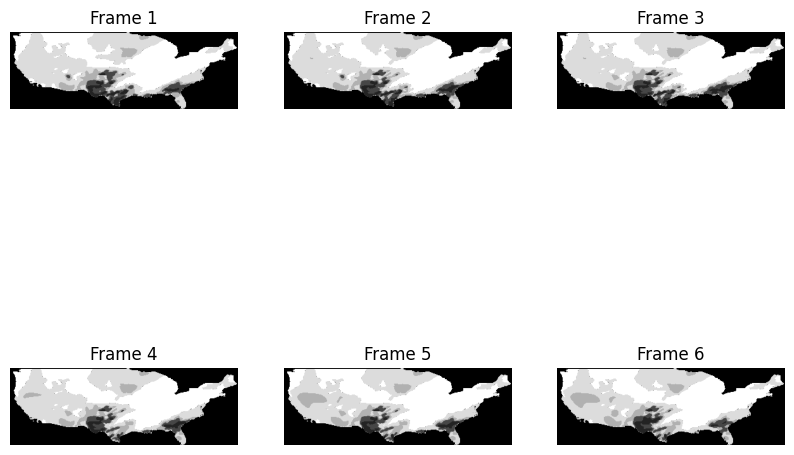

In [21]:
#Mostrar imágenes
fig, axes = plt.subplots(2, 3, figsize= (10,8))

data_choise = np.random.choice(range(len(x)), size= 1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(x[data_choise+idx]), cmap='gray')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
print("Displaying frames for example {}".format(data_choise))
plt.show()

In [22]:
x_2 = agroup_window(x, window)
print(x_2.shape)
x_train = x_2[:int(len(x_2)*.7)]
x_test = x_2[int(len(x_2)*.7):]
x_validation = x_train[int(len(x_train)*.8):]
x_train = x_train[:int(len(x_train)*.8)]

(1236, 5, 122, 360)


In [23]:
x_train = x_train.reshape(len(x_train), window, rows, cols, channels)
x_validation = x_validation.reshape(len(x_validation), window, rows, cols, channels)
x_test = x_test.reshape(len(x_test), window, rows, cols, channels)

print("Forma de datos de entrenamiento: {}".format(x_train.shape))
print("Forma de datos de validación: {}".format(x_validation.shape))
print("Forma de datos de pruebas: {}".format(x_test.shape))

Forma de datos de entrenamiento: (692, 5, 122, 360, 1)
Forma de datos de validación: (173, 5, 122, 360, 1)
Forma de datos de pruebas: (371, 5, 122, 360, 1)


In [24]:
x_train, y_train = create_shifted_frames_2(x_train)
x_validation, y_validation = create_shifted_frames_2(x_validation)
x_test, y_test = create_shifted_frames_2(x_test)

print("Training dataset shapes: {}, {}".format(x_train.shape, y_train.shape))
print("Validation dataset shapes: {}, {}".format(x_validation.shape, y_validation.shape))
print("Test dataset shapes: {}, {}".format(x_test.shape, y_test.shape))

Training dataset shapes: (692, 4, 122, 360, 1), (692, 122, 360, 1)
Validation dataset shapes: (173, 4, 122, 360, 1), (173, 122, 360, 1)
Test dataset shapes: (371, 4, 122, 360, 1), (371, 122, 360, 1)


In [25]:
np.save("DroughtDatasetMask/x_test_mask.npy", x_test)
np.save("DroughtDatasetMask/y_test_mask.npy", y_test)

In [26]:
#Construction of Convolutional LSTM network
inp = keras.layers.Input(shape=(None, *x_train.shape[2:]))
#It will be constructed a 3 ConvLSTM2D layers with batch normalization,
#Followed by a Conv3D layer for the spatiotemporal outputs.
m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(inp)
m = keras.layers.BatchNormalization()(m)
m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(m)
m = keras.layers.BatchNormalization()(m)
m = keras.layers.ConvLSTM2D(16, (3,3), padding= "same", activation= "relu")(m)
m = keras.layers.Conv2D(channels, (3,3), activation= "sigmoid", padding= "same")(m)
model = keras.models.Model(inp, m)
model.compile(loss= "binary_crossentropy", optimizer= "Adam")
print(model.summary())
#Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor= "val_loss", patience= 6, restore_best_weights= True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor= "val_loss", patience= 4)
#Define moifiable training hyperparameters
epochs = 20
batch_size = 2
#Model training
model.fit(
    x_train, y_train,
    batch_size= batch_size,
    epochs= epochs,
    validation_data= (x_validation, y_validation),
    callbacks= [early_stopping, reduce_lr]
)

2023-11-28 09:56:37.071423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 09:56:37.572531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 09:56:37.572966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 09:56:37.573354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 122, 360,   0         
                             1)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 122, 360, 1  27264     
                             6)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 122, 360, 1  64       
 ormalization)               6)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 122, 360, 1  51264     
                             6)                                  
                                                                 
 batch_normalization_1 (Batc  (None, None, 122, 360, 1  64   

2023-11-28 09:56:43.569685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/model/conv_lstm2d_2/while/model/conv_lstm2d_2/while_grad/body/_555/input/_1530' -> 'gradient_tape/model/conv_lstm2d_2/while/model/conv_lstm2d_2/while_grad/body/_555/gradient_tape/model/conv_lstm2d_2/while/gradients/AddN', 'Func/gradient_tape/model/conv_lstm2d_1/while/model/conv_lstm2d_1/while_grad/body/_750/input/_1649' -> 'gradient_tape/model/conv_lstm2d_1/while/model/conv_lstm2d_1/while_grad/body/_750/gradient_tape/model/conv_lstm2d_1/while/gradients/AddN', 'Func/gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_945/input/_1765' -> 'gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_945/gradient_tape/model/conv_lstm2d/while/gradients/AddN', 'model/conv_lstm2d_2/while/body/_367/model/conv_lstm2d_2/while/mul_2' -> 'model/con

  1/346 [..............................] - ETA: 3:04:27 - loss: 0.7642

2023-11-28 09:57:12.725007: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


346/346 [==============================] - 76s 126ms/step - loss: 0.1642 - val_loss: 0.2651 - lr: 0.0010
Epoch 2/20
346/346 [==============================] - 44s 128ms/step - loss: 0.1540 - val_loss: 0.1510 - lr: 0.0010
Epoch 3/20
346/346 [==============================] - 44s 128ms/step - loss: 0.1536 - val_loss: 0.1589 - lr: 0.0010
Epoch 4/20
346/346 [==============================] - 46s 132ms/step - loss: 0.1537 - val_loss: 0.3501 - lr: 0.0010
Epoch 5/20
346/346 [==============================] - 46s 132ms/step - loss: 0.1538 - val_loss: 0.1617 - lr: 0.0010
Epoch 6/20
346/346 [==============================] - 47s 136ms/step - loss: 0.1530 - val_loss: 0.1479 - lr: 0.0010
Epoch 7/20
346/346 [==============================] - 48s 140ms/step - loss: 0.1528 - val_loss: 0.1498 - lr: 0.0010
Epoch 8/20
346/346 [==============================] - 49s 142ms/step - loss: 0.1527 - val_loss: 0.1493 - lr: 0.0010
Epoch 9/20
346/346 [==============================] - 50s 144ms/step - loss: 0.1528

In [27]:
#Guardar el modelo
model.save("DroughtDatasetMask/ConvLSTM2D_Mask122_360.h5")

In [87]:
imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
print(imagenInicial)

1


(4, 122, 360, 1)
186/186 [==============================] - 8s 43ms/step - loss: 0.1505
El error del modelo es: 0.15047620236873627
186/186 [==============================] - 7s 37ms/step
(371, 122, 360, 1)
data: (371, 4, 122, 360, 1) y new_val: (371, 122, 360, 1)
x_test_new: (371, 3, 122, 360, 1)
CX (371, 4, 122, 360, 1)
186/186 [==============================] - 7s 37ms/step
data: (371, 4, 122, 360, 1) y new_val: (371, 122, 360, 1)
x_test_new: (371, 3, 122, 360, 1)
CX (371, 4, 122, 360, 1)
186/186 [==============================] - 7s 37ms/step
data: (371, 4, 122, 360, 1) y new_val: (371, 122, 360, 1)
x_test_new: (371, 3, 122, 360, 1)
CX (371, 4, 122, 360, 1)
186/186 [==============================] - 7s 38ms/step
data: (371, 4, 122, 360, 1) y new_val: (371, 122, 360, 1)
x_test_new: (371, 3, 122, 360, 1)
CX (371, 4, 122, 360, 1)
PREDSS (371, 4, 122, 360, 1)
Preds (371, 122, 360, 1)
Preds2 (371, 122, 360, 1)
Preds3 (371, 122, 360, 1)
Preds4 (371, 122, 360, 1)
Res_forecast (371, 4, 122

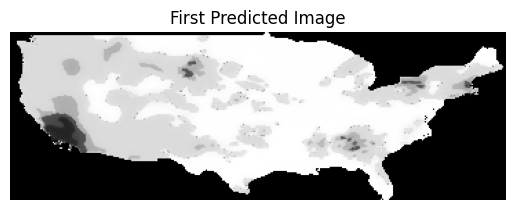

In [30]:
example = x_test[imagenInicial]

print(example.shape)

err = model.evaluate(x_test, y_test, batch_size= 2)
print("El error del modelo es: {}".format(err))
preds = model.predict(x_test, batch_size= 2)
print(preds.shape)
x_test_new = add_last(x_test, preds[:])
preds2 = model.predict(x_test_new, batch_size= 2)
#print(preds2.shape)
x_test_new = add_last(x_test_new, preds2[:])
preds3 = model.predict(x_test_new, batch_size= 2)
x_test_new = add_last(x_test_new, preds3[:])
preds4 = model.predict(x_test_new, batch_size= 2)
res_forecast = add_last(x_test_new, preds4[:])
print("PREDSS",res_forecast.shape)

np.save("DroughtDatasetMask/PredictionsConvolutionLSTM_forecast_122_360_w5.npy", res_forecast)  #Guardar el vector de predicciones

modelos = []
#agregar pred a modelos
modelos.append(preds)
modelos.append(preds2)
modelos.append(preds3)
modelos.append(preds4)


print("Preds" , preds.shape)
print("Preds2" , preds2.shape)
print("Preds3" , preds3.shape)
print("Preds4" , preds4.shape)
print("Res_forecast" , res_forecast.shape)
print("x_test" , x_test.shape)
print("x_test_new" , x_test_new.shape)
print("y_test" , y_test.shape)

# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
plt.imshow(preds[0].squeeze(), cmap='gray')
plt.title("First Predicted Image")
plt.axis('off')
plt.show()



In [90]:
data = np.load("DroughtDatasetMask/PredictionsConvolutionLSTM_forecast_122_360_w5.npy")
x_test = np.load("DroughtDatasetMask/x_test_mask.npy")
y_test = np.load("DroughtDatasetMask/y_test_mask.npy")

(371, 4, 122, 360, 1)
(371, 4, 122, 360, 1)
(371, 122, 360, 1)
(367, 4, 122, 360, 1)
COLORSS [[0.        ]
 [0.69411767]
 [0.86274511]
 [1.        ]
 [0.46666667]
 [0.27450982]
 [0.13725491]]
COLORS (7, 1)
COLORSS [[3.82275430e-05]
 [8.50382378e-08]
 [4.53273286e-09]
 ...
 [3.91417565e-08]
 [4.29623753e-07]
 [6.97719006e-05]]
XX
(367, 4, 122, 360, 1)
(367, 4, 122, 360, 1)
(367, 4, 122, 360, 1)
[4.2039626e-15]
[0.99794775]
HEY (367, 4, 122, 360, 1)
(34780, 1)
[0]
[254]
HoY (367, 4, 122, 360)
SHAPEE (367, 4, 122, 360)
DCOLORS [  0 220 177 255 119  70  35]
YCOLORS [[  0.]
 [177.]
 [220.]
 [255.]
 [119.]
 [ 70.]
 [ 35.]]
NCOLORS [[  0.]
 [255.]
 [119.]
 [220.]
 [177.]
 [ 70.]
 [ 35.]]
XS
(367, 4, 122, 360, 1)
(367, 4, 122, 360, 1)
(367, 4, 122, 360, 1)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Matriz de confusión de pronóstico
[[25559704        0        0        0        3       41     1096]
 [      94 17232807  

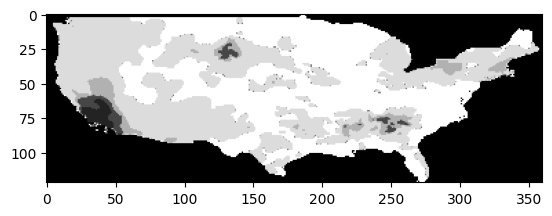

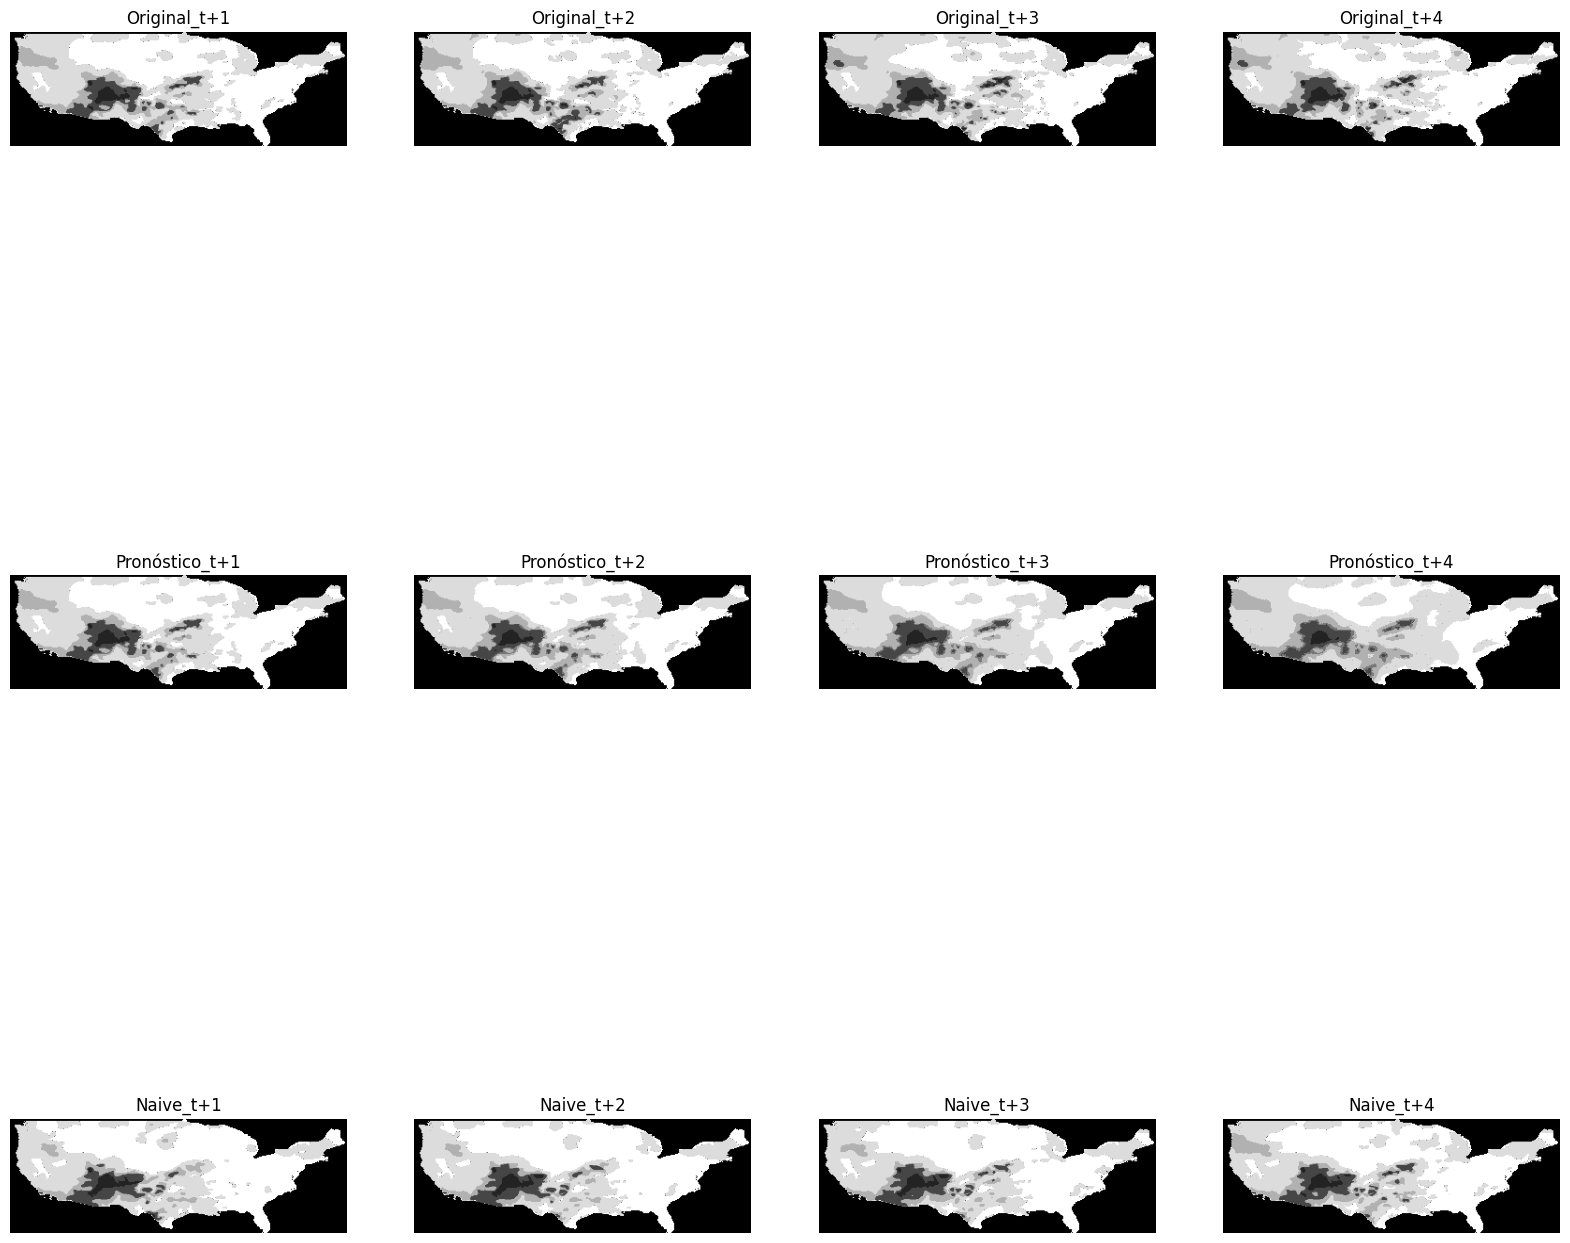

In [31]:

classes = np.array([0, 255, 220, 177, 119, 70, 35]) # 255, 220, 177, 119, 70, 35  0
classes_rgb = np.array([[0,0,0], [35,35,35], [70,70,70], [119,119,119], [177,177,177], [220,220,220], [255,255,255]])
rows = 122
cols = 360
h = 4

data = np.load("DroughtDatasetMask/PredictionsConvolutionLSTM_forecast_122_360_w5.npy")
x_test = np.load("DroughtDatasetMask/x_test_mask.npy")
y_test = np.load("DroughtDatasetMask/y_test_mask.npy")

print(data.shape)
print(x_test.shape)
print(y_test.shape)

y_test = get_cubes(y_test, h)

colors = get_colors(x_test[-10,0])
print("COLORSS", colors)
print("COLORS", colors.shape)

colorss = get_colors(data[-10,0])
print("COLORSS", colorss)

naive = x_test[:-4]
data = data[1:-3]

#y_real = y_test[:, -h:]*255
new_data = data[:, -h:]
n_real = naive[:, -h:]*255

#y_test = y_test[:, -h:]
naive = naive[:, -h:]

print("XX")
print(y_test.shape)
print(new_data.shape)
print(n_real.shape)

print(min(new_data[0,0,60]))
print(max(new_data[0,0,60]))

new_data = new_data * 255
new_data = new_data.astype(np.uint8)

print("HEY", new_data.shape)
print(colorss.shape)
print(min(new_data[0,0,60]))
print(max(new_data[0,0,60]))

new_data = new_data.reshape(new_data.shape[:-1])
print("HoY", new_data.shape)

aux = []
for i in new_data:
    aux2 = []
    for j in i:
        #res = cv2.cvtColor(j, cv2.COLOR_GRAY2RGB)
        #res = recolor_greys_image(j, classes)
        #rgb_quantized(res, classes_rgb)
        #res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
        res = gray_quantized(j, classes)
        res = recolor_greys_image(res, classes)
        aux2.append(res)
    aux.append(np.array(aux2))
new_data = np.array(aux)
print("SHAPEE", new_data.shape)
color_data = get_colors(new_data[-10,0])
print("DCOLORS", color_data)
new_data = new_data.reshape(new_data.shape[0],new_data.shape[1],new_data.shape[2],new_data.shape[3],1)

#y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2]))*255
#naive = naive.reshape((naive.shape[0], naive.shape[1], naive.shape[2])) * 255

plt.imshow(y_test[0,0], cmap="gray")
#plt.show()


plt.imshow(new_data[0,0], cmap="gray")
#plt.show()


plt.imshow(naive[0,0], cmap="gray")
#plt.show()

y_test = y_test * 255
naive = naive * 255

print("YCOLORS", get_colors(y_test[-10,0]))
print("NCOLORS", get_colors(naive[-10,0]))

print("XS")
print(new_data.shape)
print(y_test.shape)
print(naive.shape)

l_clas = len(classes)

fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(y_test[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Original_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(new_data[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Pronóstico_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(naive[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Naive_t+{}'.format(i+1))

#plt.show()

cm_f = np.zeros((l_clas, l_clas), dtype=np.uint64)
cm_n = np.zeros((l_clas, l_clas), dtype=np.uint64)
print(cm_f)

for e in range(y_test.shape[0]):
    for k in range(h):
        for i in range(rows):
            for j in range(cols):
                pos1 = np.where(classes == y_test[e, k, i, j])[0][0]
                pos2 = np.where(classes == new_data[e, k, i, j])[0][0]
                pos3 = np.where(classes == naive[e, k, i, j])[0][0]
                cm_f[pos1, pos2] += 1
                cm_n[pos1, pos3] += 1

print("Matriz de confusión de pronóstico")
print(cm_f)
print("Matriz de confusión de naive")
print(cm_n)

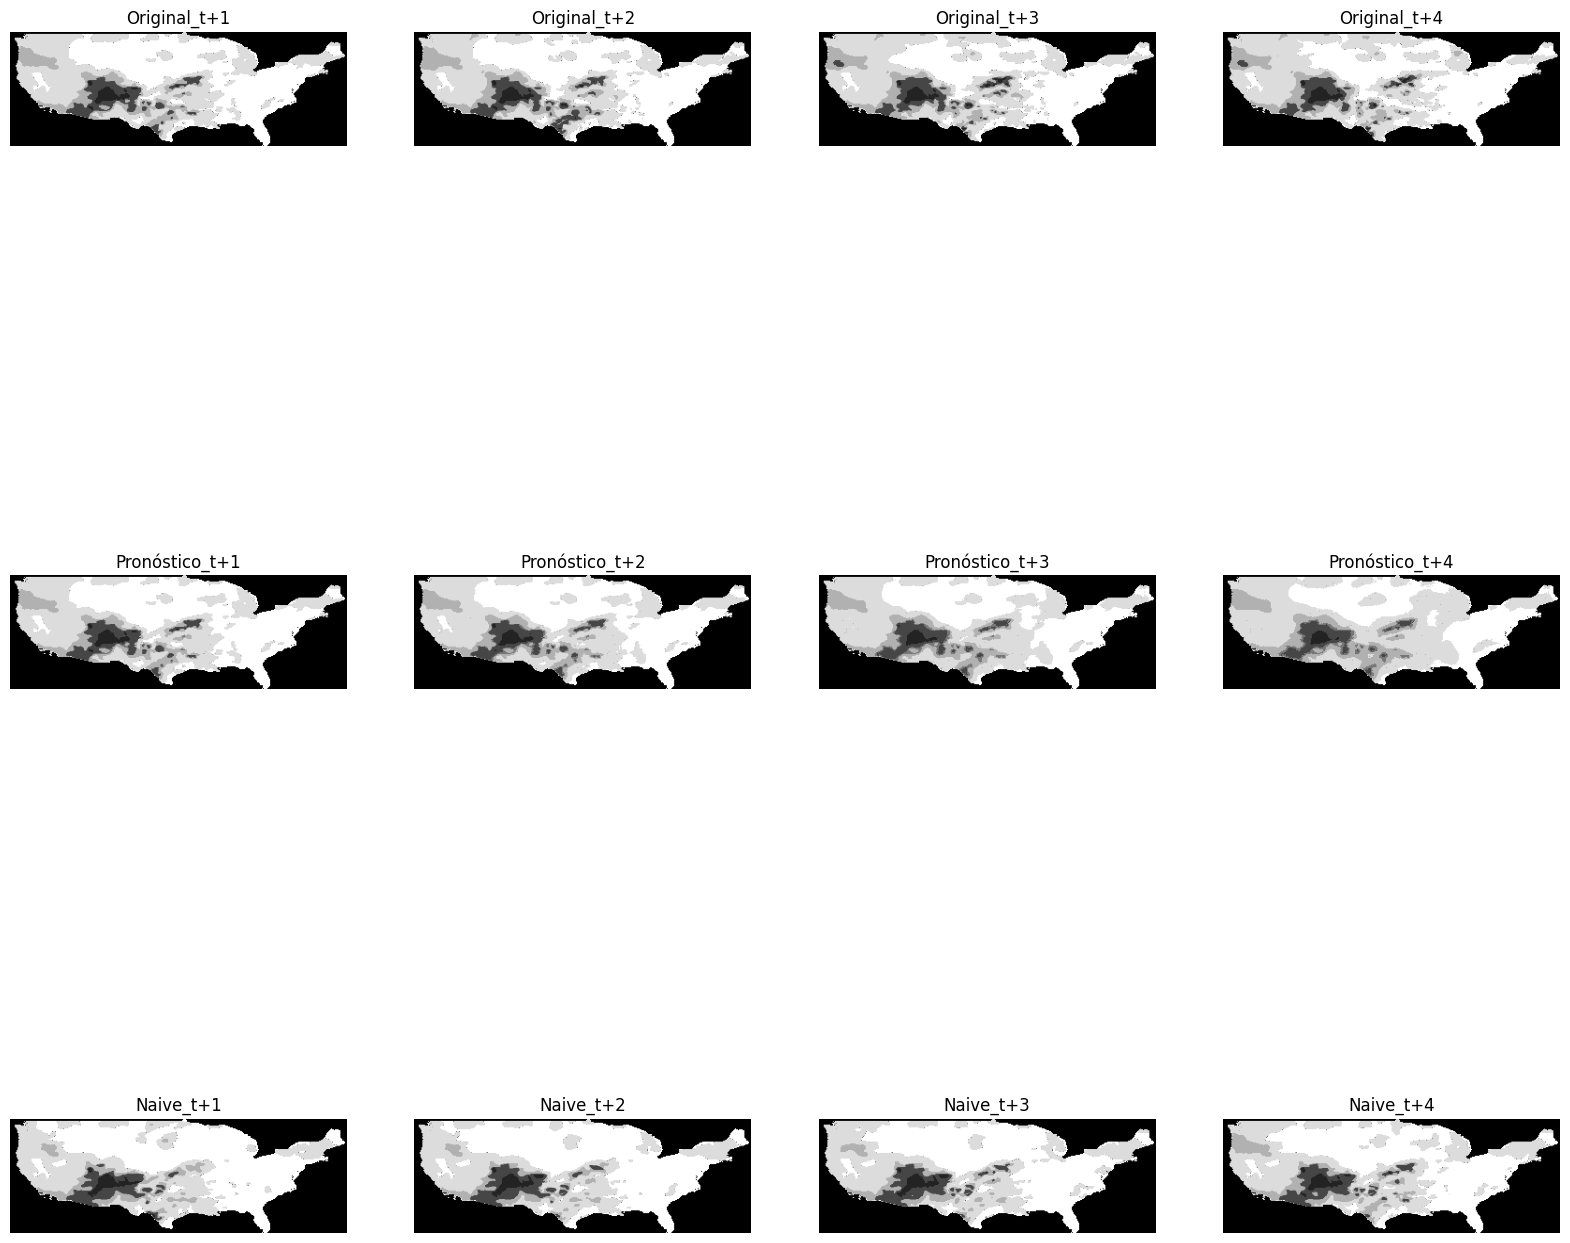

In [32]:
fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(y_test[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Original_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(new_data[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Pronóstico_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(naive[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Naive_t+{}'.format(i+1))

plt.show()

## not working

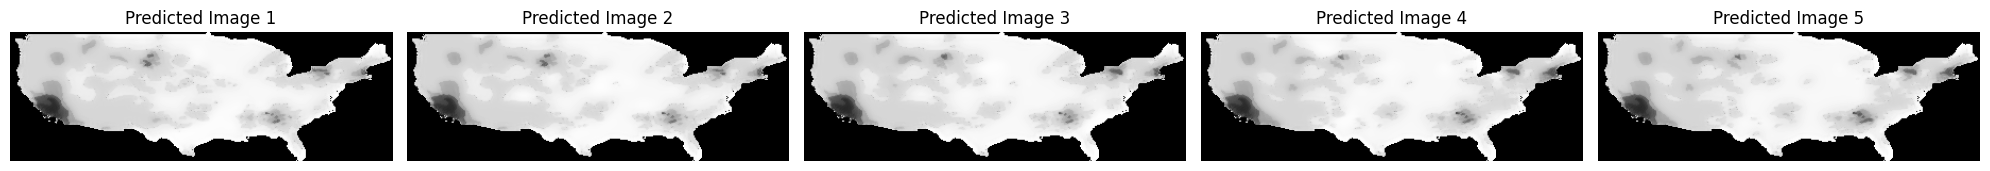

In [33]:
n_images = 5  # Define cuántas imágenes quieres mostrar
fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
for i in range(n_images):
    for j in range(len(modelos)):
        # Asegúrate de que cada imagen es una matriz 2D al usar squeeze()
        axes[i].imshow(modelos[j][i].squeeze(), cmap='gray')
        axes[i].set_title(f"Predicted Image {i+1}")
        axes[i].axis('off')
plt.tight_layout()
plt.show()

Shape of predicted: (122, 360, 1)
Shape of predicted image: (122, 360, 1)
Shape of predicted: (122, 360, 1)
Shape of predicted image: (122, 360, 1)
Shape of predicted: (122, 360, 1)
Shape of predicted image: (122, 360, 1)
Shape of predicted: (122, 360, 1)
Shape of predicted image: (122, 360, 1)
Shape of predicted: (122, 360, 1)
Shape of predicted image: (122, 360, 1)


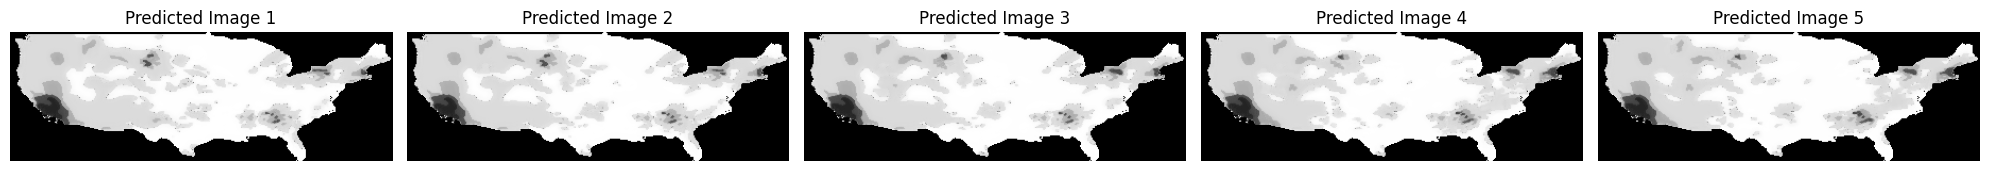

In [34]:
n_images = 5  # Define cuántas imágenes quieres mostrar
fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
for i in range(n_images):
    #Asegúrate de que cada imagen es una matriz 2D al usar squeeze()
    print(f"Shape of predicted: {preds[i].shape}")
    axes[i].imshow(preds[i].squeeze(), cmap='gray')
    print(f"Shape of predicted image: {preds[i].shape}")
    axes[i].set_title(f"Predicted Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [88]:
print(range(len(x_test)))

range(0, 4)


In [79]:
imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
print(imagenInicial)

1


(4, 122, 360, 1)
(4, 122, 360, 1)
1/1 [==============================] - 0s 24ms/step
example (4, 122, 360, 1)
(4, 122, 360, 1)
1/1 [==============================] - 0s 22ms/step
example (4, 122, 360, 1)
(4, 122, 360, 1)
1/1 [==============================] - 0s 21ms/step
example (4, 122, 360, 1)
(4, 122, 360, 1)
1/1 [==============================] - 0s 23ms/step
example (4, 122, 360, 1)
(1, 122, 360, 1)


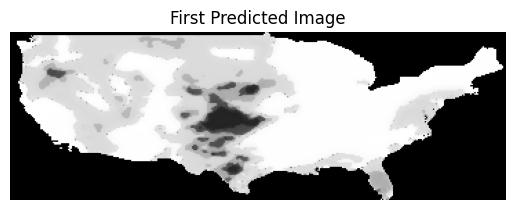

In [36]:

example = x_test[imagenInicial]
#frames = example[:4, ...]
#original_frames = example[4:, ...]
print(example.shape)
#print(frames.shape)
#print(original_frames.shape)
for _ in range(horizon):
    print(example.shape)
    new_prediction = model.predict(example.reshape(1,*example.shape[0:]))
    example = np.concatenate((example[1:], new_prediction), axis=0)
    print(f"example {example.shape}")
predictions = example[:-3]
print(predictions.shape)
# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
plt.imshow(predictions[0].squeeze(), cmap='gray')
plt.title("First Predicted Image")
plt.axis('off')
plt.show()

In [40]:

example = x_test[imagenInicial]
#frames = example[:4, ...]
#original_frames = example[4:, ...]
print(example.shape)
#print(frames.shape)
#print(original_frames.shape)
for _ in range(horizon):
    print(example.shape)
    new_prediction = model.predict(example.reshape(1,*example.shape[0:]))
    example = np.concatenate((example[1:], new_prediction), axis=0)
    print(f"example {example.shape}")
predictions = example[:-3]
print(predictions.shape)
# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()

for i in range(horizon):
    plt.imshow(example[i].squeeze(), cmap='gray')
    plt.title(f"{i+1} Predicted Image")
    plt.axis('off')
    plt.show()

IndexError: index 346 is out of bounds for axis 0 with size 4

In [39]:
x_test = x_test[imagenInicial]
for i in range(horizon):
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"{i+1} x_test Image")
    plt.axis('off')
    plt.show()

IndexError: index 346 is out of bounds for axis 0 with size 4